# Patient Stratification

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from clusteval import clusteval
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import os
import sys
import logging
import io
from mpl_toolkits import mplot3d

from venny4py.venny4py import *
from venn import venn


In [9]:
nblog = open("rf_prediction.log", "w")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
os.environ['PYTHONUTF8'] = '1'

In [10]:
dir ='emif'

if dir == 'emif':
    df = pd.read_excel('../data/'+dir+'/EMIF-AD TMT data Proteins (preprocessed).xlsx')
    df.dropna(subset = ['Amyloid.abnormal'], inplace = True)
    patient_code = df['sample.id']
    patient_group = df['Amyloid.abnormal']
    df.drop(columns = ['Unnamed: 0', 'sample.id','Amyloid.abnormal', 'TMT.reporter', 'TMT.set', 'Diagnosis', 'Age', 'Gender', 'APOEdich', 'MMSE', 'Eduy'], inplace = True) # drop unwanted columns
    df.dropna(axis = 1, inplace = True) # drop proteins with nan values
    df = df.apply(lambda x: np.log2(x))
    print(len(df.columns))
    print(len(df))
else:
    df = pd.read_csv('../data/'+dir+'/data.csv', encoding='utf-8')
    patient_code = df['Code']
    patient_group = df['Group']
    df.drop(columns = ['Code','Group'], inplace = True) # drop unwanted columns
df

C:\Users\danis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


570
437


,P04114,P01024,P02768,P02751,P01023,P0C0L4,P0C0L5,P02787,Q9Y6R7,Q9NYQ8,...,P01127,A0A075B6K0,Q9HC57,P0DP58,A0A0A0MRZ8,P62328,O75093,Q86UP8,Q5SYB0,Q9BZF9
6,-1.162217,0.039528,0.058344,0.223374,0.021593,-0.225067,0.186621,-0.104451,-0.561116,0.825560,...,-0.063194,-0.180267,-0.037113,-0.267162,-0.258918,0.002288,0.122857,0.085576,0.385541,-0.413512
7,-1.402352,-0.047898,-0.372126,0.317120,-0.278585,0.205917,0.708418,-0.289408,0.188862,-0.502056,...,-0.170592,-0.974449,-0.291582,0.160511,-0.603751,0.004438,-0.068258,-0.020591,0.325657,-0.073860
8,-0.954719,0.073373,-0.306331,0.195256,-0.101030,0.372602,0.331099,-0.280705,-0.451266,-0.216133,...,0.154510,-0.460826,-0.022477,0.159511,-0.245577,0.109998,0.360710,-0.068509,0.232512,0.015252
9,-0.719360,0.502766,0.616278,-0.307584,0.061966,0.362947,0.424054,0.345256,-0.625669,-0.017060,...,-0.350186,-0.058847,-0.603167,-0.787982,0.539791,-0.292273,-0.437829,0.720821,-0.131298,1.385193
10,-0.484424,-0.389341,-0.651718,-0.035561,-0.309437,0.017457,0.054169,-0.269573,0.279665,-0.254529,...,-0.136751,-0.987509,0.138644,0.138644,-0.687638,-0.002511,0.010001,1.421296,0.443607,-0.636037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-1.807355,-0.200533,-0.543862,-0.222392,-0.180782,-0.442034,0.003143,-0.393695,-0.332983,0.528819,...,-0.065991,-0.128251,0.320354,0.041865,-0.952035,0.171847,0.297494,-0.295813,0.139362,-0.772000
476,-1.083518,-0.168324,-0.248248,-0.069109,-0.293593,0.224222,0.450474,-0.171207,-0.262522,-0.153998,...,0.091828,-0.868644,0.660130,-0.268683,-0.210201,-0.159711,0.238772,-1.110929,-7.400026,0.015294
477,-1.619979,-0.194918,-0.404170,0.002802,-0.192779,-0.227388,0.264903,-0.384508,0.371374,0.105445,...,-0.040776,-0.525433,0.479940,0.026863,-0.631520,0.054136,-0.117817,0.394320,0.096728,-0.538954
478,-0.069019,0.840106,0.557672,0.097173,0.456417,0.242326,0.683203,0.443875,0.235550,-0.149087,...,0.041657,0.268166,-0.101740,-0.115287,-0.173356,0.113103,-0.021868,-0.460289,0.072401,-0.053525


In [11]:
folder_path = '../data/'+dir+'/results_new'
os.makedirs(folder_path, exist_ok = True)

**Feature selection RF** 

In [12]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]


def sens(y_true, y_pred): return tp(y_true, y_pred) / \
    (fn(y_true, y_pred) + tp(y_true, y_pred))


def spec(y_true, y_pred): return tn(y_true, y_pred) / \
    (fp(y_true, y_pred) + tn(y_true, y_pred))

sensitivity_scorer = make_scorer(sens)

# Specificity scorer
specificity_scorer = make_scorer(spec)

# AUC scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# accuracy scorer
accuracy_scorer = make_scorer(accuracy_score)


C:\Users\danis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [13]:
# get ranked features list
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df, patient_group)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({'Feature': df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances

,Feature,Importance
345,P62258,0.051884
267,P31150,0.038615
282,P63104,0.031720
153,P04075,0.019547
208,Q9Y2T3,0.016385
...,...,...
508,Q16653,0.000110
540,P52797,0.000081
224,Q96PD5,0.000069
536,O95445,0.000061


In [14]:
results = []
# Get feature names sorted by importance
ranked_features = feature_importances['Feature'].tolist()

for k in range(1,len(df.columns)+1):
    print(k)   
    top_n_features = ranked_features[:k]

    param_grid = {
        'n_estimators': [10, 100, 200,300],
        'max_depth': [None, 10,20,30],
        'min_samples_split': [2, 10], 
        'min_samples_leaf': [1, 2,4],
        'class_weight' : [None, 'balanced'],
        'max_features' : ['sqrt', 'log2', None]}
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, cv= RepeatedStratifiedKFold(n_repeats = 1), scoring='accuracy', n_jobs=-1)
    grid_search.fit(df[top_n_features], patient_group)

    # Get the index of the best model (based on accuracy score)
    best_index = grid_search.best_index_
    
    # Store results
    results.append({
    'best_params': grid_search.best_params_,
    'best_accuracy': grid_search.best_score_,
    'best_std_accuracy' :  grid_search.cv_results_['std_test_score'][best_index],
    '#features': k,
    'features': top_n_features
    })
    print('Accuracy: ', grid_search.best_score_)

# Find the best classifier based on accuracy
best_result = max(results, key=lambda x: x['best_accuracy'])
best = f"Number of features: {best_result['#features']}\n" + "Features:" + str(best_result['features']) +"\n" + \
f"Best Params: {best_result['best_params']}" +"\n" + f"Best Accuracy: {best_result['best_accuracy']:.4f} +/- {best_result['best_std_accuracy']:.4f}" 


# Create the LaTeX table as a string
latex_table = f"""
\\begin{{table}}[htbp]
\\centering
\\caption{{Selected Features {dir}}}
\\begin{{tabular}}{{|l|l|}}
\\hline
\\textbf{{Classifier Parameters}} & {best_result['best_params']} \\\\
\\hline
\\textbf{{Number of Features}} & {best_result['#features']} \\\\
\\hline
\\textbf{{Feature List}} & {', '.join(best_result['features'])} \\\\
\\hline
\\textbf{{Best Accuracy}} & {best_result['best_accuracy']:.2f} $\\pm$ {best_result['best_std_accuracy']:.2f} \\\\
\\hline
\\end{{tabular}}
\\label{{tab:best_classifier}}
\\end{{table}}
"""
print(best)
#print(latex_table)

with open(f'selected_feautres_{dir}.txt', 'w') as f:
    f.write(latex_table)


1
Accuracy:  0.7713949843260189
2
Accuracy:  0.76444618599791
3
Accuracy:  0.810005224660397
4
Accuracy:  0.8030825496342737
5
Accuracy:  0.7963166144200626
6
Accuracy:  0.807601880877743
7
Accuracy:  0.8055381400208986
8
Accuracy:  0.8190700104493207
9
Accuracy:  0.8123040752351096
10
Accuracy:  0.8033176593521422
11
Accuracy:  0.8146812957157785
12
Accuracy:  0.8122779519331245
13
Accuracy:  0.8168756530825496
14
Accuracy:  0.8122779519331245
15
Accuracy:  0.8170323928944618
16
Accuracy:  0.8145506792058516
17
Accuracy:  0.816901776384535
18
Accuracy:  0.821551724137931
19
Accuracy:  0.8236938349007314
20
Accuracy:  0.8307993730407525
21
Accuracy:  0.8283176593521422
22
Accuracy:  0.8330721003134796
23
Accuracy:  0.8330459770114942
24
Accuracy:  0.8284221525600837
25
Accuracy:  0.835135841170324
26
Accuracy:  0.8192267502612329
27
Accuracy:  0.8282915360501567
28
Accuracy:  0.8330198537095089
29
Accuracy:  0.83521421107628
30
Accuracy:  0.83521421107628
31
Accuracy:  0.83301985370950

KeyboardInterrupt: 

In [ ]:
lis_coim = pd.read_csv('../data/Lisbon+Coimbra/all_samples.csv')
if dir == 'emif':
    features = []
    features_name = []
    for feature in features:
        if feature in lis_coim['Accession Number']:
            features_name.append(lis_coim.loc[lis_coim['Accession Number'] == feature]['Short name'])
        else:
            print(feature + ' not in Lisbon and Coimbra')
    print(features_name)

**Results**

Lisbon

    Features:['NRP2', 'COMP', 'NBL1', 'FETUA', 'A1AG1', 'APOA1', 'PGS2', 'DCC', 'HRG', 'APOL1', 'FBLN2', 'ITIH4', 'LFNG', 'C1QC', 'COEA1', 'FHR2', 'HEP2', 'IBP7', 'CNTP2', 'TTHY', 'ISLR', 'APLP1', 'FRIL', 'LV657', 'NCAN', 'ALS', 'CO6', 'A2GL', 'SLIK4', 'RTN4R', 'GRIA4', 'RENR', 'HPRT', 'NPTXR', 'SPRC', 'CO3', 'CNTN1', 'ENPP2', '1433G', 'PTGDS', 'ALDOC', 'LDHA', 'GLU2B', 'MRC1', 'CD166']

Coimbra

    Features: ['APOH', 'HEMO', 'IBP7', 'RNAS1', 'TTHY', 'GLYLB', 'CIP4', 'KV113', 'CNTP2']

Both Cohorts:

    Intersection of features:['CNTP2', 'TTHY', 'IBP7']
    Features: ['FETUA', 'IBP7', 'ENPP2', 'GLYLB', 'NBL1', 'FBLN2', 'PGS2', 'CFAI', 'C1QC', 'CO3', 'AACT', 'MYO6', 'DCC', 'VASN', 'SIAE', 'SCG1', 'C1S', 'APOA4', '1433G', 'SCG3', 'APOA1', 'CD109', 'CATF', 'CNTN1', 'NID2', 'NRP2', 'FINC', 'APOH', 'COMP', 'FHR2', 'HEP2', 'MRC2']

**Clustering** 

In [98]:
%matplotlib inline
def clustering(df_clust, patient_code):

    # Initialize clustering
    ce = clusteval(cluster='agglomerative', linkage='ward', evaluate='silhouette', max_clust=3)

    # Fit
    results = ce.fit(df_clust)
    cluster_labels = results['labx']

    # Plot
    #fig = plt.figure(figsize = (20, 10))
     
    #ax = plt.axes(projection ="3d")
    
    # Creating plot
    #ax.scatter3D(df_clust[:,0], df_clust[:,1],df_clust[:,2], c=cluster_labels, cmap='viridis', s=50)
    #ax.set_xlabel('CNTP2') 
    #ax.set_ylabel('TTHY') 
    #ax.set_zlabel('IBP7')
    
    # show plot
    
    # Step 3: Reduce dimensionality for scatter plot (using PCA for 2D)
    tsne = TSNE(n_components=2, perplexity=15)
    X_tsne = tsne.fit_transform(df_clust)

    # Step 4: Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=50)

    # Step 5: Annotate points with labels (here, we're using the original cluster labels)
    for i in range(X_tsne.shape[0]):
        plt.text(X_tsne[i, 0], X_tsne[i, 1], '%s' % patient_code[i], fontsize=8, ha='center')
    #ax.set_box_aspect(None, zoom=0.75)
    plt.show()
    ce.plot()
    ce.plot_silhouette(cmap = 'bwr')
    ce.dendrogram()
    df = pd.DataFrame({'Code': patient_code, 'Cluster':
                       cluster_labels})
    df.to_csv(folder_path + '/clusters_results_each_norm.csv', index=False)

    

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 1/1 [00:00<00:00, 514.07it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


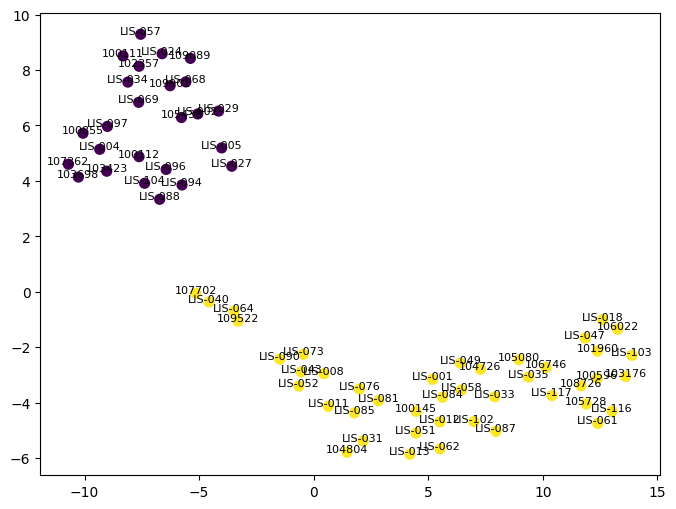

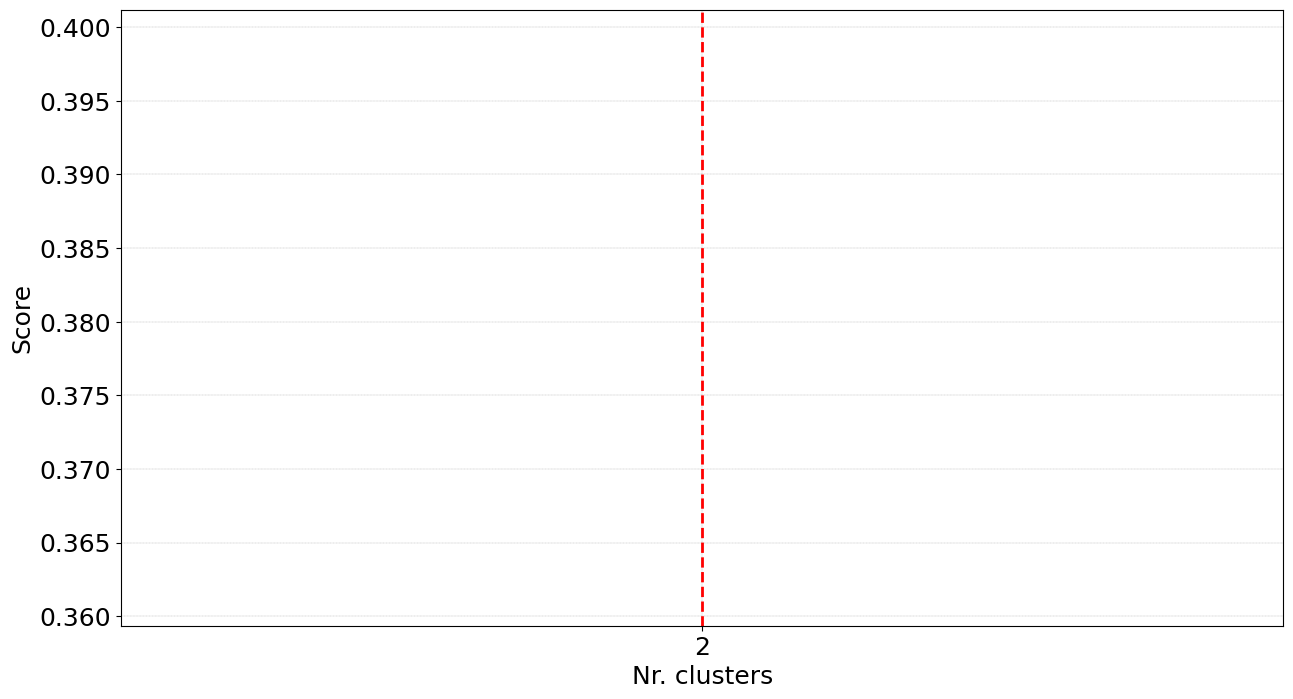

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 2, average silhouette_score=0.461


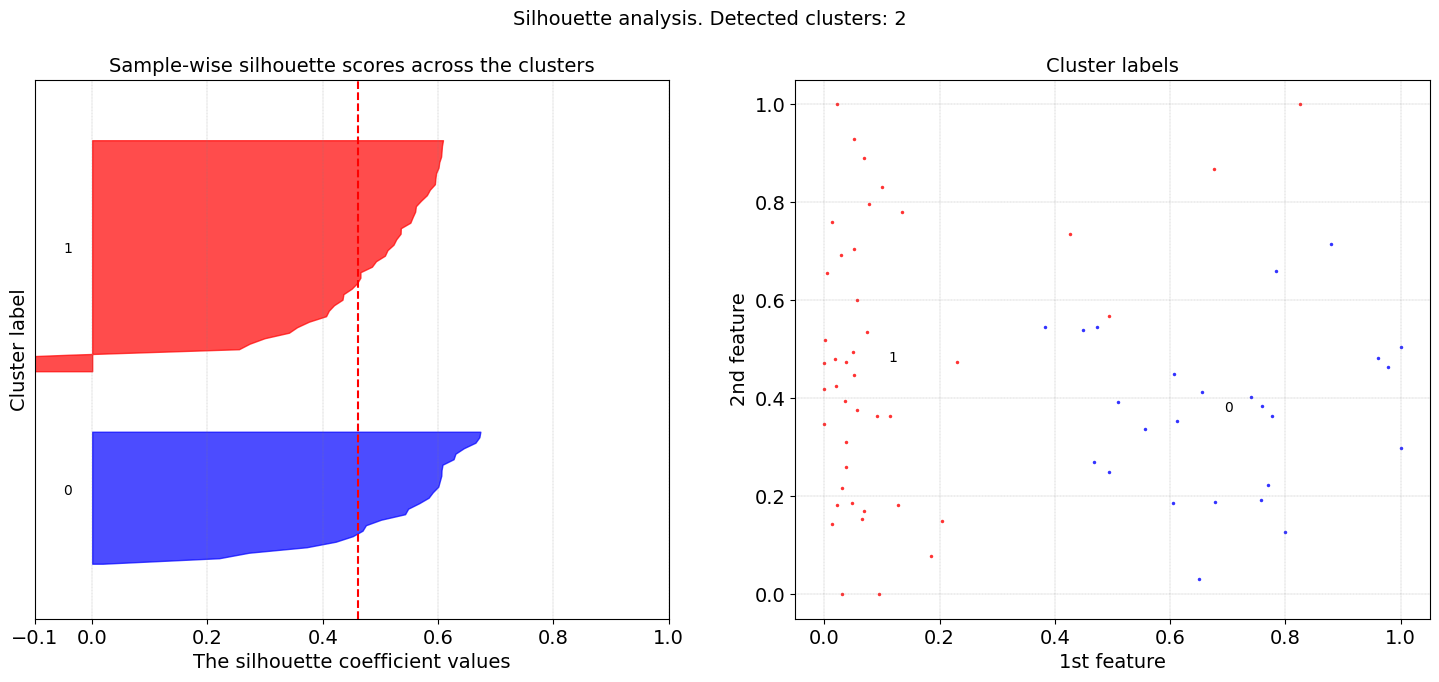

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=3.138. Be patient now..
[clusteval] >INFO> Compute cluster labels.


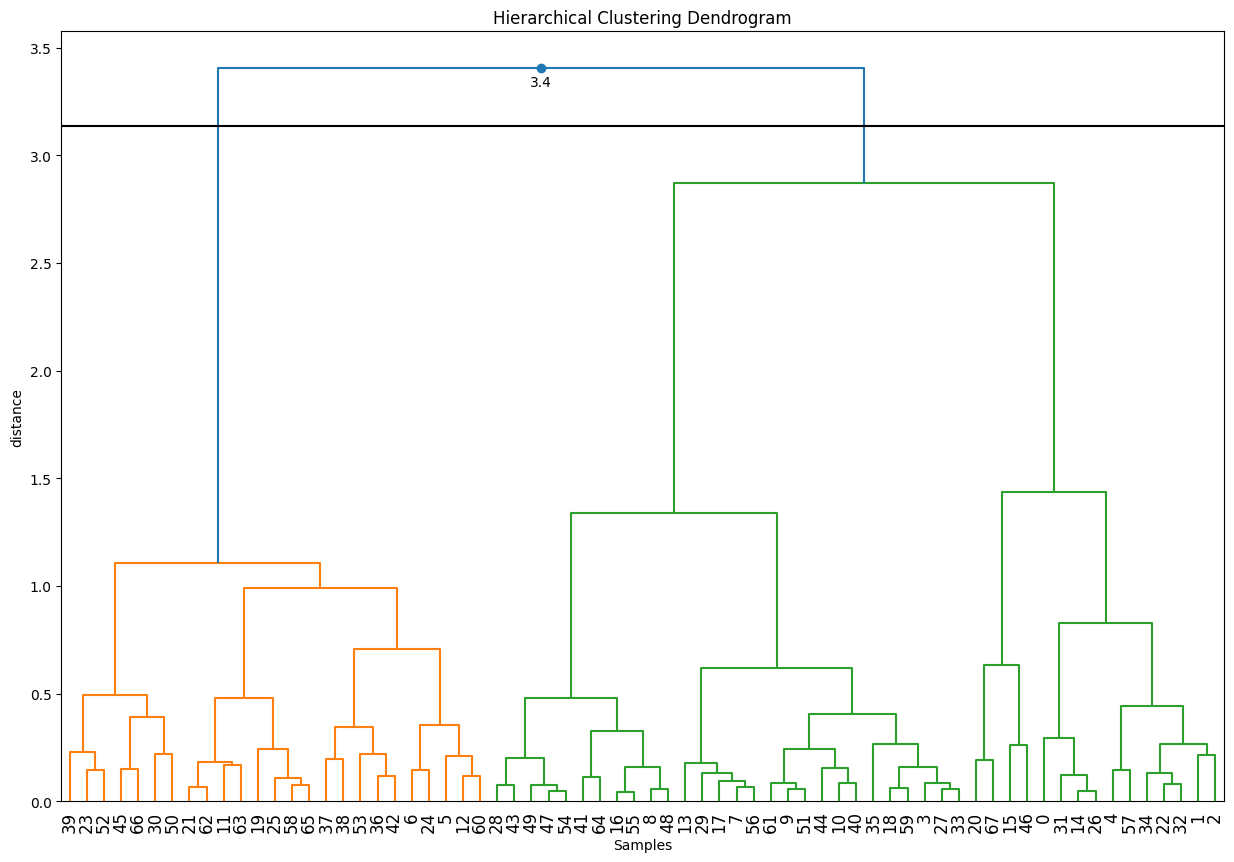

In [99]:
#if dir == 'lisbon':
features_lisbon = ['NRP2', 'COMP', 'NBL1', 'FETUA', 'A1AG1', 'APOA1', 'PGS2', 'DCC', 'HRG', 'APOL1', 'FBLN2', 'ITIH4', 'LFNG', 'C1QC', 'COEA1', 'FHR2', 'HEP2', 'IBP7', 'CNTP2', 'TTHY', 'ISLR', 'APLP1', 'FRIL', 'LV657', 'NCAN', 'ALS', 'CO6', 'A2GL', 'SLIK4', 'RTN4R', 'GRIA4', 'RENR', 'HPRT', 'NPTXR', 'SPRC', 'CO3', 'CNTN1', 'ENPP2', '1433G', 'PTGDS', 'ALDOC', 'LDHA', 'GLU2B', 'MRC1', 'CD166']
#elif dir == 'coimbra':
features_coimbra = ['APOH', 'HEMO', 'IBP7', 'RNAS1', 'TTHY', 'GLYLB', 'CIP4', 'KV113', 'CNTP2']
#else:
#features = set(features_lisbon).union(features_coimbra)
#features = list(features)
#print(len(features))
#print(features)
features = ['CNTP2', 'TTHY', 'IBP7']
    #features = ['FETUA', 'IBP7', 'ENPP2', 'GLYLB', 'NBL1', 'FBLN2', 'PGS2', 'CFAI', 'C1QC', 'CO3', 'AACT', 'MYO6', 'DCC', 'VASN', 'SIAE', 'SCG1', 'C1S', 'APOA4', '1433G', 'SCG3', 'APOA1', 'CD109', 'CATF', 'CNTN1', 'NID2', 'NRP2', 'FINC', 'APOH', 'COMP', 'FHR2', 'HEP2', 'MRC2']
df_clust = df[features]
df_clust = df_clust.loc[patient_group == 'MCI-AD'].values

patient_code_clust = list(patient_code.loc[patient_group == 'MCI-AD'])
lis_index = []
coim_index = []
for i, s in enumerate(patient_code_clust):
    if s.startswith('LIS'):
        lis_index.append(i)
    else:
        coim_index.append(i)

#print(df_clust.apply(lambda x: x.str.encode('ascii', 'ignore').decode('ascii') if x.dtype == "object" else x))
scaler = MinMaxScaler()
df_clust[lis_index] = scaler.fit_transform(df_clust[lis_index])
df_clust[coim_index] = scaler.fit_transform(df_clust[coim_index])
#df_clust = scaler.fit_transform(df_clust)
clustering(df_clust, patient_code_clust)

**Comparing Selected features** 

Intersection of Lis and Coim: {'IBP7', 'CNTP2', 'TTHY'}
Intersection of Lis and Lis+Coim: {'FBLN2', 'NRP2', 'FETUA', 'DCC', 'ENPP2', 'COMP', 'CO3', 'APOA1', 'IBP7', 'NBL1', 'HEP2', 'CNTN1', 'PGS2', 'C1QC', 'FHR2', '1433G'}
Intersection of Coim and Lis+Coim: {'APOH', 'IBP7', 'GLYLB'}


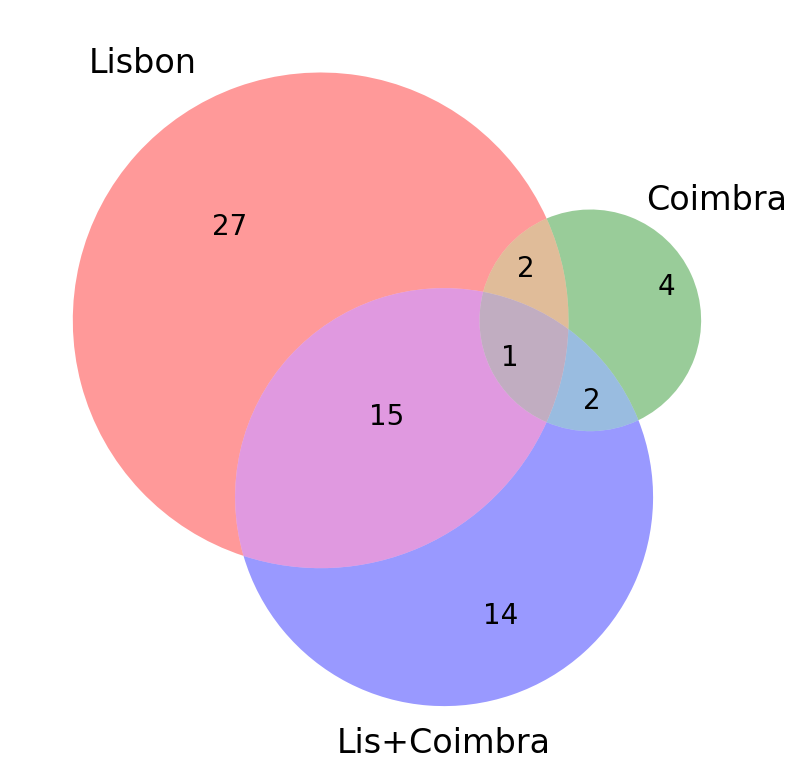

In [29]:
set1 = set(['NRP2', 'COMP', 'NBL1', 'FETUA', 'A1AG1', 'APOA1', 'PGS2', 'DCC', 'HRG', 'APOL1', 'FBLN2', 'ITIH4', 'LFNG', 'C1QC', 'COEA1', 'FHR2', 'HEP2', 'IBP7', 'CNTP2', 'TTHY', 'ISLR', 'APLP1', 'FRIL', 'LV657', 'NCAN', 'ALS', 'CO6', 'A2GL', 'SLIK4', 'RTN4R', 'GRIA4', 'RENR', 'HPRT', 'NPTXR', 'SPRC', 'CO3', 'CNTN1', 'ENPP2', '1433G', 'PTGDS', 'ALDOC', 'LDHA', 'GLU2B', 'MRC1', 'CD166'])
set2 = set(['APOH', 'HEMO', 'IBP7', 'RNAS1', 'TTHY', 'GLYLB', 'CIP4', 'KV113', 'CNTP2'])
set3 = set(['FETUA', 'IBP7', 'ENPP2', 'GLYLB', 'NBL1', 'FBLN2', 'PGS2', 'CFAI', 'C1QC', 'CO3', 'AACT', 'MYO6', 'DCC', 'VASN', 'SIAE', 'SCG1', 'C1S', 'APOA4', '1433G', 'SCG3', 'APOA1', 'CD109', 'CATF', 'CNTN1', 'NID2', 'NRP2', 'FINC', 'APOH', 'COMP', 'FHR2', 'HEP2', 'MRC2'])
venn3([set1, set2, set3], ('Lisbon', 'Coimbra', 'Lis+Coimbra'))
# Calculate intersections
intersection_12 = set1 & set2
intersection_13 = set1 & set3
intersection_23 = set2 & set3
intersection_123 = set1 & set2 & set3
# Print intersection results
print("Intersection of Lis and Coim:", intersection_12)
print("Intersection of Lis and Lis+Coim:", intersection_13)
print("Intersection of Coim and Lis+Coim:", intersection_23)


**Comparing Patients** 

<Axes: >

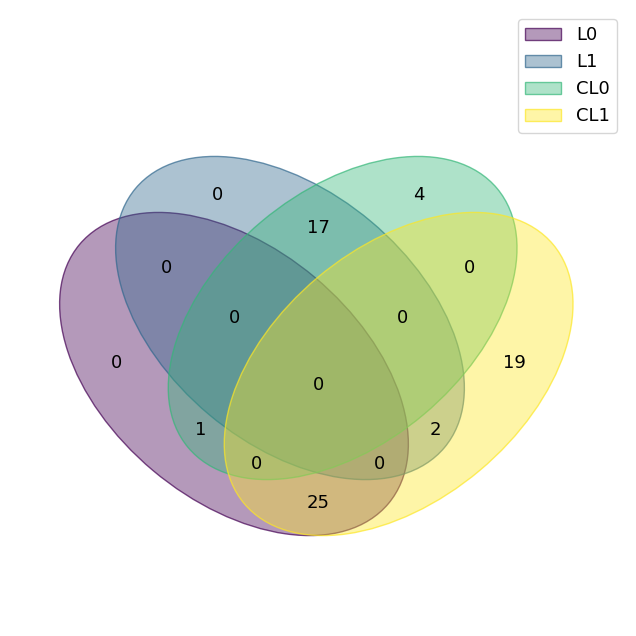

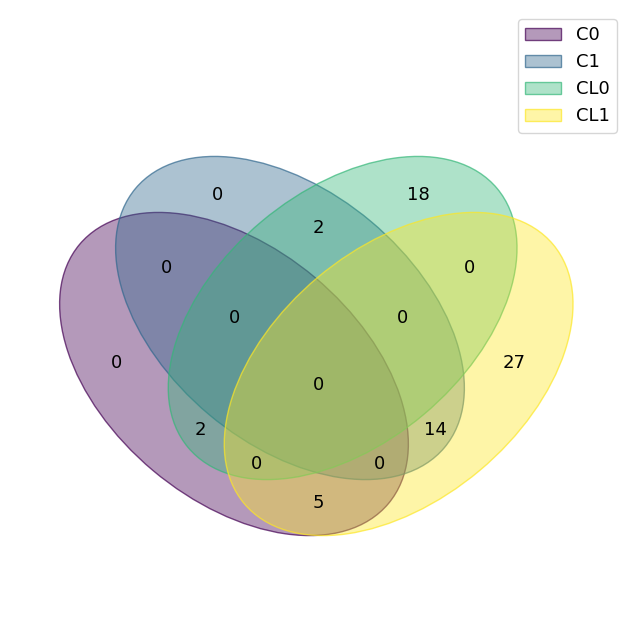

In [97]:
lisbon = pd.read_csv('../data/lisbon/results/clusters_results.csv')
l0 = set(lisbon.loc[lisbon['Cluster'] == 0]['Code'])
l1 = set(lisbon.loc[lisbon['Cluster'] == 1]['Code'])
coimbra = pd.read_csv('../data/coimbra/results/clusters_results.csv')
c0 = set(coimbra.loc[coimbra['Cluster'] == 0]['Code'].astype(str))
c1 = set(coimbra.loc[coimbra['Cluster'] == 1]['Code'].astype(str))
lis_coim = pd.read_csv('../data/lisbon+coimbra/results_new/clusters_results_each_norm.csv')
cl0 = set(lis_coim.loc[lis_coim['Cluster'] == 0]['Code'])
cl1 = set(lis_coim.loc[lis_coim['Cluster'] == 1]['Code'])
cl2 = set(lis_coim.loc[lis_coim['Cluster'] == 2]['Code'])

#dict of sets
sets = {
    'L0': l0,
    'L1': l1,
    'CL0': cl0,
    'CL1': cl1}

# Plot Venn diagram for l1, l0, and cl1, cl0, c1, c0 sets
venn(sets)  


#dict of sets
sets = {
    'C0': c0,
    'C1': c1,
    'CL0': cl0,
    'CL1': cl1}

# Plot Venn diagram for l1, l0, and cl1, cl0, c1, c0 sets
venn(sets)  
# Calculate intersections
#intersection_13 = (l0 | l1) & (cl0 | cl1)  # Lisbon & Lisbon+Coimbra
#intersection_23 = (c0 | c1) & (cl0 | cl1)  # Coimbra & Lisbon+Coimbra

# Print intersection results
#print("Intersection of Lis and Lis+Coim:", intersection_13)
#print("Intersection of Coim and Lis+Coim:", intersection_23)
